# 模型理解与 Captum

[Captum](https://captum.ai/)（拉丁语中的“理解”）是开源的、可扩展的模型可解释性库，构建在 PyTorch 之上。

随着模型复杂性的增加和随之而来的透明度的缺乏，模型可解释性方法变得越来越重要。模型理解既是活跃的研究领域，也是跨行业使用机器学习的实际应用的关注点。Captum 提供了最先进的算法，包括 Integrated Gradients，为研究人员和开发人员提供了一种简单的方法来理解哪些特征对模型的输出有贡献。

完整的文档、API 参考和一系列关于特定主题的教程可在 [captum.ai](https://captum.ai/) 网站上找到。

## 简介

Captum 的模型可解释性方法是通过*归因*来实现的。Captum 中有三种归因类型：

-   **特征归因** 试图通过生成输出的输入特征来解释特定的输出。通过评论中的某些词语来解释电影评论是正面还是负面的例子就是特征归因的一个例子。
-   **层归因** 在特定输入之后检查模型隐藏层的活动。检查卷积层对输入图像的响应的空间映射输出是层归因的一个例子。
-   **神经元归因** 类似于层归因，但专注于单个神经元的活动。

在本交互式笔记本中，我们将研究特征归因和层归因。

每种归因类型都有多个**归因算法**与之相关联。许多归因算法分为两大类：

-   **基于梯度的算法** 计算模型输出、层输出或神经元激活相对于输入的反向梯度。**Integrated Gradients**（用于特征）、**Layer Gradient \* Activation** 和 **Neuron Conductance** 都是基于梯度的算法。
-   **基于扰动的算法** 检查模型、层或神经元对输入变化的输出变化。输入扰动可以是定向的或随机的。**Occlusion**、**Feature Ablation** 和 **Feature Permutation** 都是基于扰动的算法。

我们将在下面研究这两种类型的算法。

特别是在涉及大型模型的情况下，以与正在检查的输入特征相关的方式可视化归因数据可能是有价值的。虽然使用 Matplotlib、Plotly 或类似工具创建自己的可视化是可能的，但 Captum 提供了专门用于其归因的增强工具：

-   `captum.attr.visualization` 模块（导入为 `viz`）提供了有助于可视化与图像相关的归因的实用函数。
-   **Captum Insights** 是 Captum 之上的一个易于使用的 API，提供了带有现成可视化的可视化小部件，适用于图像、文本和任意模型类型。

这两种可视化工具集都将在本笔记本中演示。前几个示例将专注于计算机视觉用例，但 Captum Insights 部分将在多模型、视觉问答模型中演示归因的可视化。

## 安装

在开始之前，您需要 Python 环境，其中包含：

-   Python 版本 3.6 或更高
-   对于 Captum Insights 示例，Flask 1.1 或更高版本和 Flask-Compress（推荐最新版本）
-   PyTorch 版本 1.2 或更高（推荐最新版本）
-   TorchVision 版本 0.6 或更高（推荐最新版本）
-   Captum（推荐最新版本）
-   Matplotlib 版本 3.3.4，因为 Captum 目前使用了一个在较新版本中参数名称已更改的 Matplotlib 函数

要在 Anaconda 或 pip 虚拟环境中安装 Captum，请使用适合您环境的以下命令：

使用 `conda`：

```bash
conda install pytorch torchvision captum flask-compress matplotlib=3.3.4 -c pytorch
```

使用 `pip`：

```bash
pip install torch torchvision captum matplotlib==3.3.4 Flask-Compress
```

在您设置的环境中重新启动此笔记本，您就可以开始了！

## 示例

首先，从简单的视觉示例开始。在 ImageNet 数据集上预训练的 ResNet 模型开始。获取测试输入，并使用不同的 **特征归因** 算法来检查输入图像如何影响输出，并查看一些测试图像的有用输入归因图的可视化。

首先，导入一些库：

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

使用 TorchVision 模型库下载预训练的 ResNet。由于不进行训练，现在将其置于评估模式。

In [2]:
model = models.resnet18(weights='IMAGENET1K_V1')
model = model.eval()

加载图片：

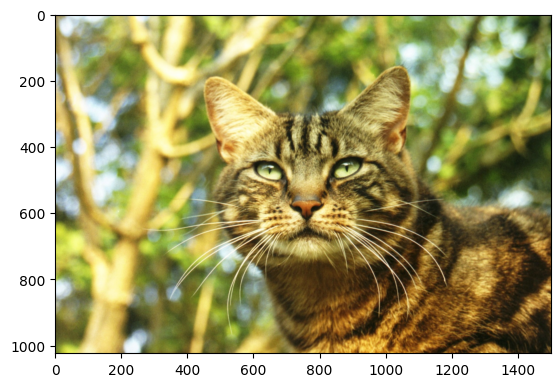

In [6]:
test_img = Image.open('../images/cat.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

ResNet 模型是在 ImageNet 数据集上训练的，并期望图像具有特定的大小，通道数据归一化到特定范围的值。还将获取模型识别的类别的人类可读标签列表。

In [7]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

labels_path = '../images/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

现在，可以问一个问题：模型认为这张图像代表什么？

In [8]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: tabby ( 0.56882244348526 )


已经确认 ResNet 认为这张猫的图像实际上是一只猫。但是 *为什么* 模型认为这是一张猫的图像呢？

为了找到答案，转向 Captum。

## 特征归因与 Integrated Gradients

**特征归因** 将特定输出归因于输入的特征。它使用特定的输入 - 这里是我们测试图像 - 生成相对重要性图，显示每个输入特征对特定输出特征的重要性。

[Integrated Gradients](https://captum.ai/api/integrated_gradients.html) 是 Captum 中可用的特征归因算法之一。Integrated Gradients 通过近似模型输出相对于输入的梯度的积分，为每个输入特征分配一个重要性分数。

在我们的例子中，我们将采用输出向量的特定元素 - 即模型对其选择的类别的置信度 - 并使用 Integrated Gradients 来理解输入图像的哪些部分对这一输出有贡献。

一旦我们从 Integrated Gradients 获得了重要性图，我们将使用 Captum 中的可视化工具来提供重要性图的有用表示。Captum 的 `visualize_image_attr()` 函数提供了多种自定义显示归因数据的选项。在这里，我们传入一个自定义的 Matplotlib 颜色映射。

运行带有 `integrated_gradients.attribute()` 调用的单元格通常需要一两分钟。

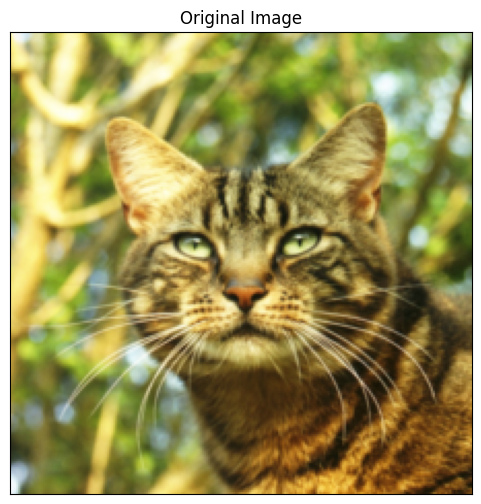

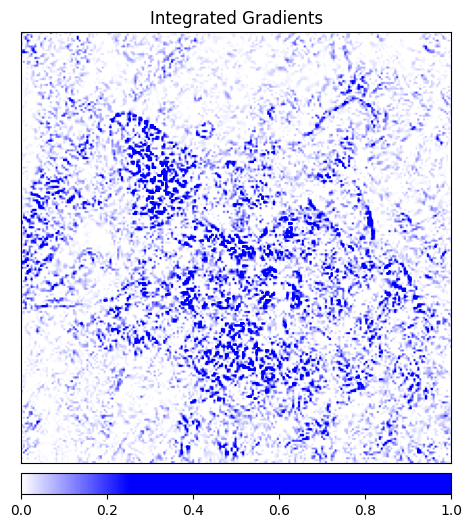

In [9]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to 
attributions_ig = integrated_gradients.attribute(input_img, target=pred_label_idx, n_steps=200)

# Show the original image for comparison
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)), 
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

在上面的图像中，您应该看到 Integrated Gradients 在图像中猫的位置附近给出了最强的信号。

## 特征归因与遮挡

基于梯度的归因方法通过直接计算输出相对于输入的变化来帮助理解模型。*基于扰动的归因*方法更直接地通过引入输入的变化来测量对输出的影响。[遮挡](https://captum.ai/api/occlusion.html) 就是其中一种方法。它涉及替换输入图像的部分区域，并检查对输出信号的影响。

下面，我们设置遮挡归因。与配置卷积神经网络类似，您可以指定目标区域的大小和步长，以确定各个测量的间距。使用 `visualize_image_attr_multiple()` 可视化遮挡归因的输出，显示区域正负归因的热图，并通过用正归因区域遮罩原始图像。遮罩给出了我们猫照片中模型认为最“像猫”的区域的非常有指导性的视图。

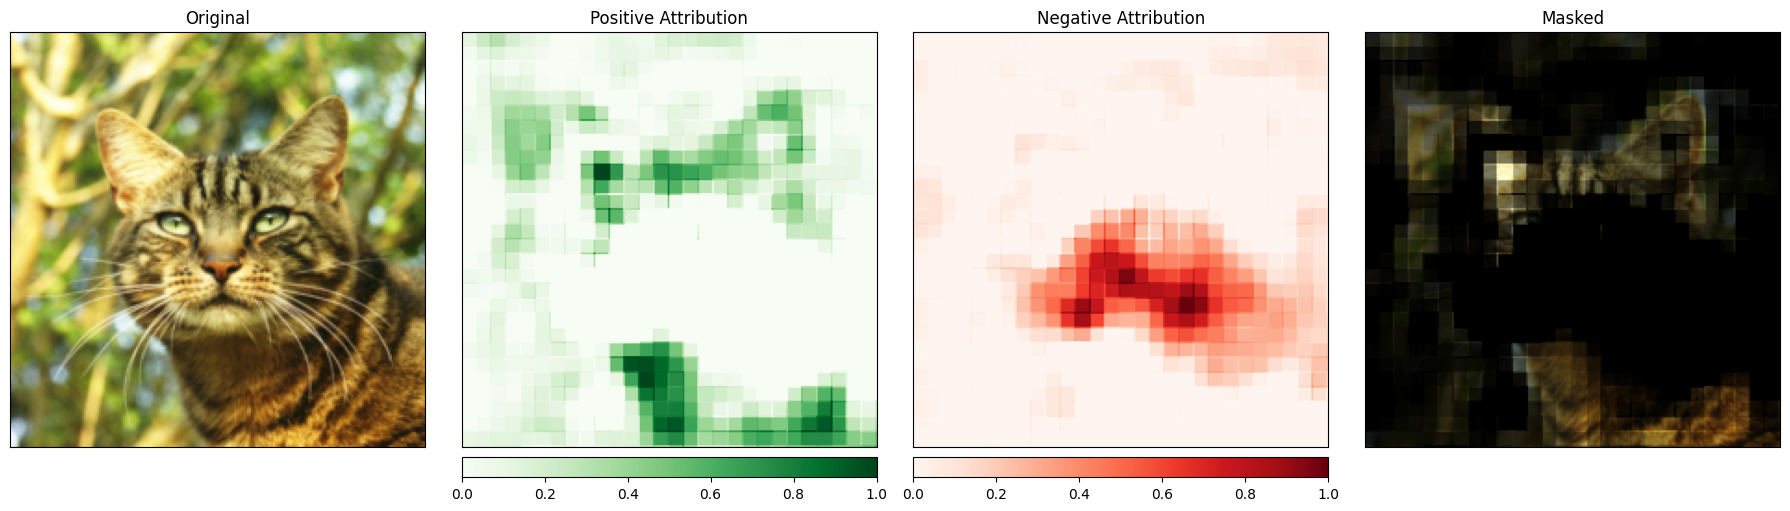

In [10]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input_img,
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )

同样，看到图像中包含猫的区域被赋予了更大的重要性。

## 层归因与 Layer GradCAM
====================================

**层归因** （Layer Attribution）允许模型中隐藏层的活动归因于输入的特征。下面，使用层归因算法来检查模型中卷积层的活动。

GradCAM 计算目标输出相对于给定层的梯度，对每个输出通道（输出维度的第2维）取平均值，并将每个通道的平均梯度乘以层激活。结果在所有通道上求和。GradCAM 是为卷积网络设计的；由于卷积层的活动通常与输入空间映射，GradCAM 归因通常会上采样并用作输入的遮罩。

层归因的设置类似于输入归因，除了必须指定模型外，您还必须指定模型中要检查的隐藏层。与上面一样，当我们调用 `attribute()` 时，我们指定感兴趣的目标类别。

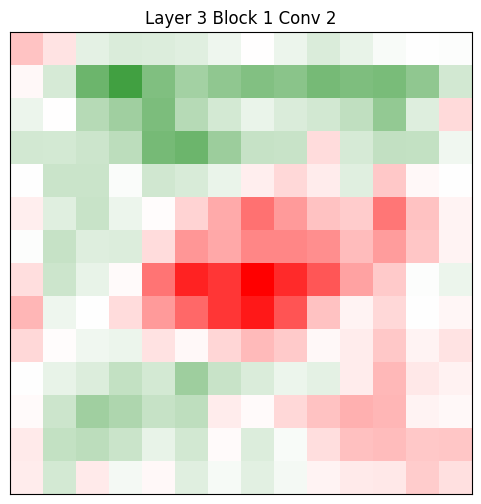

In [11]:
layer_gradcam = LayerGradCam(model, model.layer3[1].conv2)
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)

_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Layer 3 Block 1 Conv 2")

使用 [LayerAttribution](https://captum.ai/api/base_classes.html?highlight=layerattribution#captum.attr.LayerAttribution) 基类中的便捷方法 `interpolate()` 对这些归因数据进行上采样，以便与输入图像进行比较。

torch.Size([1, 1, 14, 14])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


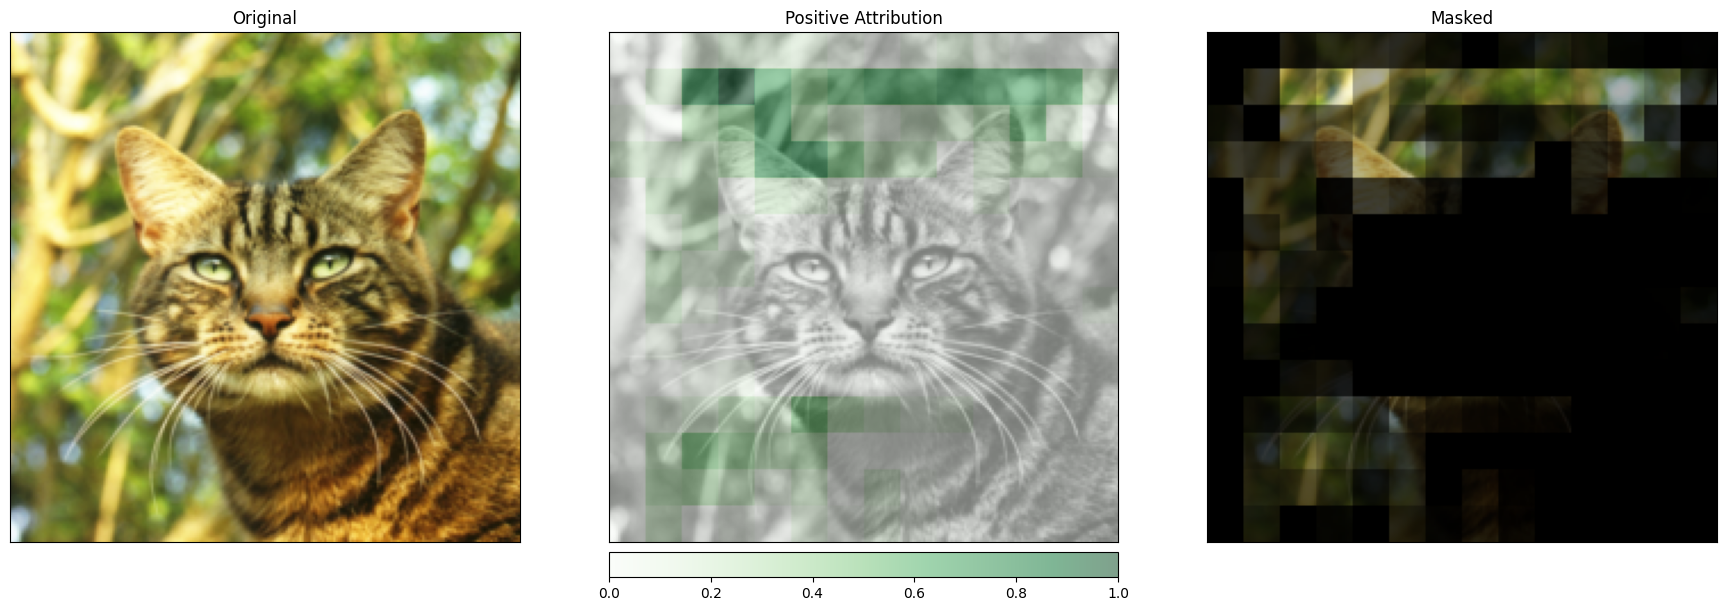

In [12]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input_img.shape)

_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))

这样的可视化可以为您提供关于隐藏层如何响应输入的新见解。

## 可视化与 Captum Insights

Captum Insights 是建立在 Captum 之上的可解释性可视化小部件，旨在促进模型理解。Captum Insights 适用于图像、文本和其他特征，帮助用户理解特征归因。它允许您可视化多个输入/输出对的归因，并提供图像、文本和任意数据的可视化工具。

在本笔记本的这一部分，我们将使用 Captum Insights 可视化多个图像分类推断。

首先，让我们获取一些图像，看看模型对它们的看法。为了多样性，我们将使用我们的猫、茶壶和三叶虫化石：

In [13]:
imgs = ['../images/cat.jpg', '../images/teapot.jpg', '../images/trilobite.jpg']

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

Predicted: tabby / 281  ( 0.56882244348526 )
Predicted: teapot / 849  ( 0.9914799928665161 )
Predicted: trilobite / 69  ( 0.9999061822891235 )


...看起来我们的模型正确识别了所有图像 - 当然，我们想深入挖掘。为此，我们将使用 Captum Insights 小部件，我们使用下面导入的 `AttributionVisualizer` 对象进行配置。`AttributionVisualizer` 期望批量数据，因此我们将引入 Captum 的 `Batch` 辅助类。我们特别关注图像，因此我们还将导入 `ImageFeature`。

我们使用以下参数配置 `AttributionVisualizer`：

-   要检查的模型数组（在我们的例子中，只有一个）
-   评分函数，允许 Captum Insights 从模型中提取前 k 个预测
-   模型训练的类别的有序、人类可读的列表
-   要查找的特征列表 - 在我们的例子中，是一个 `ImageFeature`
-   数据集，这是一个返回输入和标签批次的可迭代对象 - 就像您在训练中使用的那样

In [14]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    return i


input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k][1], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[282,849,69])]
)

请注意，运行上面的单元格并没有花费太多时间，不像我们上面的归因。这是因为 Captum Insights 允许您在可视化小部件中配置不同的归因算法，之后它将计算并显示归因。*这个*过程将需要几分钟。

运行下面的单元格将渲染 Captum Insights 小部件。然后，您可以选择归因方法及其参数，根据预测类别或预测正确性过滤模型响应，查看模型的预测及其相关概率，并查看与原始图像相比的归因热图。

In [ ]:
visualizer.render()

CaptumInsights(insights_config={'classes': ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhe…

Output()